In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, OneCycleLR
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_

current_directory = os.getcwd()
mnist_directory = os.path.join(current_directory,"../MNIST_CSV")


print("Current Directory:", current_directory)
print("MNIST Directory:", mnist_directory)


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current Directory: c:\Users\Sai\Work\cs490
MNIST Directory: c:\Users\Sai\Work\cs490\MNIST_CSV


In [2]:
# Enable GPU usage for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Defining model architecture
To apply resnet18 to MNIST data we need to define our model architecture using pytorch. This task has been done by dozens of computer scientists before so finding pre-existing implementations of the architecture was quite easy. In fact, resnet18 is so popular for these tasks that there was an option to import the model altogether without redefining the model architecture but recreating it allows for opportunities for modification later and better interpretability of what the CNN is doing. 

Residual networks create a block for the input data and pass the original block of data combined with output from the previous layer into the next layer. This prevents loss of data integrity and vanishing gradients as the input gets propagated deeper into the network.

<p align="center"><img src="images/resnet18ex1.png" alt="Diagram showing the skip block" width="75%"/> </br> This diagram shows the original block "skipping" a layer and being passed as input into the next layer </p>
<p align="center"><img src="images/resnet18ex2.png" alt="Diagram showing the layers of Resnet18" width="75%"/></br> This diagram visualizes the internal layers specifications</p>

We can see the intricacies of each layer. The data is first convoluted into a block which is passed to other layers. Resnet has 8 layers of convolutional filters before being pooled. In this example, the output is softmaxed but for our purposes we modify it to use a linear output to predict one of the 10 classes. 

In [3]:
# Architecture Sourced From: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb
# Resnet Paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
# https://www.researchgate.net/figure/ResNet-18-architecture-20-The-numbers-added-to-the-end-of-ResNet-represent-the_fig2_349241995
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

# Define the BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNetMNIST(nn.Module):
    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNetMNIST, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [4]:
# Create the ResNet18 model
NUM_CLASSES = 10  # Number of classes in MNIST
GRAYSCALE = True  # Since MNIST is grayscale
resnet18_model = ResNetMNIST(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
resnet18_model.to(device)

ResNetMNIST(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

### Loading the Data
MNIST data is pretty clean. All we needed to do is open the dataframe from the csv file and extract our data and labels. MNIST will use the grayscale version of this neural network so the pixel values are normalized to a range of 0 to 1. 

The data is then converted to a tensor dataset and loaded for pytorch. To speed up computation we push the tensors to a GPU if available.

In [5]:
# Load the data from CSVs using pandas
mnist_train = pd.read_csv(os.path.join(mnist_directory, "mnist_train.csv"), header=None)
mnist_train.head()

mnist_test = pd.read_csv(os.path.join(mnist_directory, "mnist_test.csv"), header=None)
mnist_test.head()

# Extract labels and pixel values
train_labels = mnist_train.iloc[:, 0].values
train_images = mnist_train.iloc[:, 1:].values / 255.0  # Normalize pixel values to the range [0, 1]

test_labels = mnist_test.iloc[:, 0].values
test_images = mnist_test.iloc[:, 1:].values / 255.0  # Normalize pixel values to the range [0, 1]

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [6]:
# Reshape the images to [batch_size, 1, 28, 28]
train_images_tensor = train_images_tensor.view(-1, 1, 28, 28)
test_images_tensor = test_images_tensor.view(-1, 1, 28, 28)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Move the data to the GPU
train_images_tensor, train_labels_tensor = train_images_tensor.to(device), train_labels_tensor.to(device)
test_images_tensor, test_labels_tensor = test_images_tensor.to(device), test_labels_tensor.to(device)


### Training the Model
Training the model is straightforward: the resnet18 model is initialized with the learning rate and cross entropy loss function hyperparameters, and then training is run for a certain number of epochs by passing in image data into the neural network.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed
# max_grad_norm = 1.0

# Compute Train Accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for _, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        _, class_probabilities = model(features)
        _, predicted_labels = torch.max(class_probabilities, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

# While training run nvidia-smi in the terminal to check gpu tasks 
train_accuracies = []
train_losses = []

# Training the model
num_epochs = 15
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    epoch_losses = []

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)
        outputs, _ = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # clip_grad_norm_(resnet18_model.parameters(), max_grad_norm)
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate training accuracy
        current_lr = optimizer.param_groups[0]['lr']
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}')
    scheduler.step()
    
    training_accuracy = compute_accuracy(resnet18_model, train_loader, device)
    train_accuracies.append(training_accuracy)

    # epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
    
    # train_losses.append(epoch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {training_accuracy:.4f}')
    
print('Training finished.')

Epoch [1/15], Step [100/938], Loss: 0.1430, Learning Rate: 0.001000
Epoch [1/15], Step [200/938], Loss: 0.0671, Learning Rate: 0.001000
Epoch [1/15], Step [300/938], Loss: 0.1808, Learning Rate: 0.001000
Epoch [1/15], Step [400/938], Loss: 0.1735, Learning Rate: 0.001000
Epoch [1/15], Step [500/938], Loss: 0.0183, Learning Rate: 0.001000
Epoch [1/15], Step [600/938], Loss: 0.1161, Learning Rate: 0.001000
Epoch [1/15], Step [700/938], Loss: 0.0560, Learning Rate: 0.001000
Epoch [1/15], Step [800/938], Loss: 0.0146, Learning Rate: 0.001000
Epoch [1/15], Step [900/938], Loss: 0.1747, Learning Rate: 0.001000
Epoch [1/15], Training Accuracy: 97.8450
Epoch [2/15], Step [100/938], Loss: 0.1059, Learning Rate: 0.001000
Epoch [2/15], Step [200/938], Loss: 0.0211, Learning Rate: 0.001000
Epoch [2/15], Step [300/938], Loss: 0.0270, Learning Rate: 0.001000
Epoch [2/15], Step [400/938], Loss: 0.0042, Learning Rate: 0.001000
Epoch [2/15], Step [500/938], Loss: 0.0405, Learning Rate: 0.001000
Epoch [

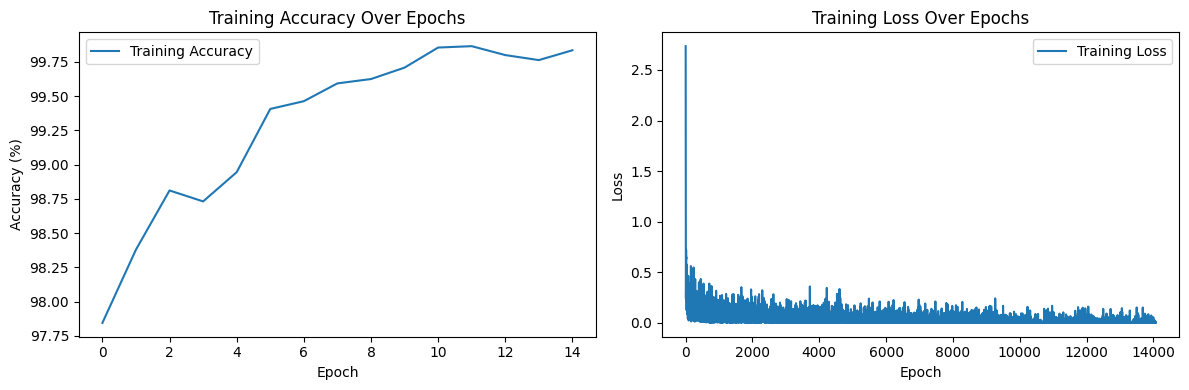

In [11]:
# Plotting training accuracies and losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
torch.save(resnet18_model.state_dict(), 'resnet18_mnist_model.pth')

### Testing the Model
Using the test tensor we initialized above, we can set the model into evaluation mode and then record how accurate it is at making predictions. MNIST in the resnet18 model achieved ~99% accuracy

In [10]:
# Load the test data
mnist_test = pd.read_csv(os.path.join(mnist_directory, "mnist_test.csv"), header=None)

# Extract labels and pixel values
test_labels = mnist_test.iloc[:, 0].values
test_images = mnist_test.iloc[:, 1:].values / 255.0  # Normalize pixel values to the range [0, 1]

# Convert to PyTorch tensor
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Reshape the images to [batch_size, 1, 28, 28]
test_images_tensor = test_images_tensor.view(-1, 1, 28, 28)

# Move the test data to the GPU
test_images_tensor, test_labels_tensor = test_images_tensor.to(device), test_labels_tensor.to(device)

# Create TensorDataset and DataLoader for the test data
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test data
resnet18_model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs, _ = resnet18_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 99.36%
